In [1]:
using Revise

In [4]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [5]:
using PotentialFlow

In [6]:
using CairoMakie
#using Plots
#pyplot()

┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1664


In [7]:
using LaTeXStrings

In [8]:
using Distributions
using Random
using LinearAlgebra
#using Clustering
#using GaussianMixtures

In [9]:
Random.seed!(1234)

TaskLocalRNG()

### Evaluation grids and sensors

In [429]:
# grid for full field evaluation
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)
zg = xg .+ im*yg';

# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 11
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 11
lowerrow = range(-2.0,2.0,length=Nsens) .- 0.0*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Truth

In [432]:
Nv_cluster = 3 #3
Nv_per_cluster = 1 #5
δ_true = 0.1
xr = (-1.5,1.5)
yr = (0.1,1.0)
Γr = (0.0,2.0)
σx = 0.03
σΓ = 0.03
Nv_true = Nv_cluster*Nv_per_cluster 

zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)

config_data_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state_reordered(vort,config_data_true);

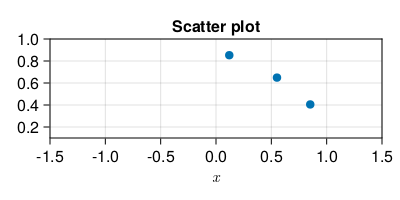

In [433]:
scatter(real.(zv),imag.(zv);
            figure = (; resolution = (400, 200)),
            axis = (; limits=(xr,yr),title = "Scatter plot", xlabel = L"x",aspect=DataAspect()))
    #,ratio=1,xlim=xr,ylim=yr,legend=false)

In [434]:
Γv

3-element Vector{Float64}:
 1.0551748477450031
 1.9441715970174493
 0.6837232167606334

In [435]:
ptrue_field = analytical_pressure(zg,vort,config_data_true);

In [436]:
#=
f, ax, l1 = contour(xg,yg,ptrue_field,levels=LinRange(-1,0.1,31),colormap=:RdBu;
    figure = (; resolution = (400, 400)),
    axis=(;aspect=1))
l2 = scatter!(real(sens),imag(sens))
f
=#

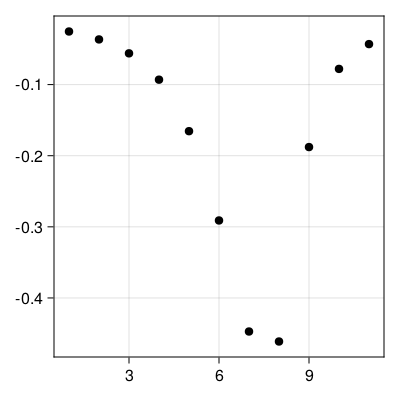

In [437]:
obs_true = PressureObservations(sens,config_data_true);
ystar = observations(x_true,obs_true);
f = plot(ystar; figure = (; resolution = (400, 400)))

## Single vortex estimation

In [446]:
Nv_one = 3
δ = 0.1

config_1vortex_data = VortexConfig(Nv_one, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #1e-3
ϵX = 5e-3 #0.05
ϵΓ = 5e-3 #0.05

# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,1.5)
Γr = (0.0,2.0)

obs = PressureObservations(sens,config_1vortex_data);

In [447]:
sol_collection = vortexinference(ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,obs; linear_flag=false,numsample=50,maxiter=250,errtol=0.025,inflate=true);

#### Classify the trajectories

In [448]:
sol_goodones, minyerr = classify_by_yerr(sol_collection,obs);
sol_bestones, clustersize = classify_by_density(sol_goodones,obs);

xtoplist = collect_estimated_states(sol_bestones,obs.config)
xtop_array = states_to_vortex_states(xtoplist,obs.config);

bestsol = sol_bestones[1]
xbest = mean(bestsol[end].X)
xbest_array = state_to_vortex_states(xbest,obs.config)

3×3 Matrix{Float64}:
 0.0736943  0.737937  -0.637889
 0.691617   0.40877    1.18263
 1.05565    2.31691    0.237441

#### Plotting the trajectories

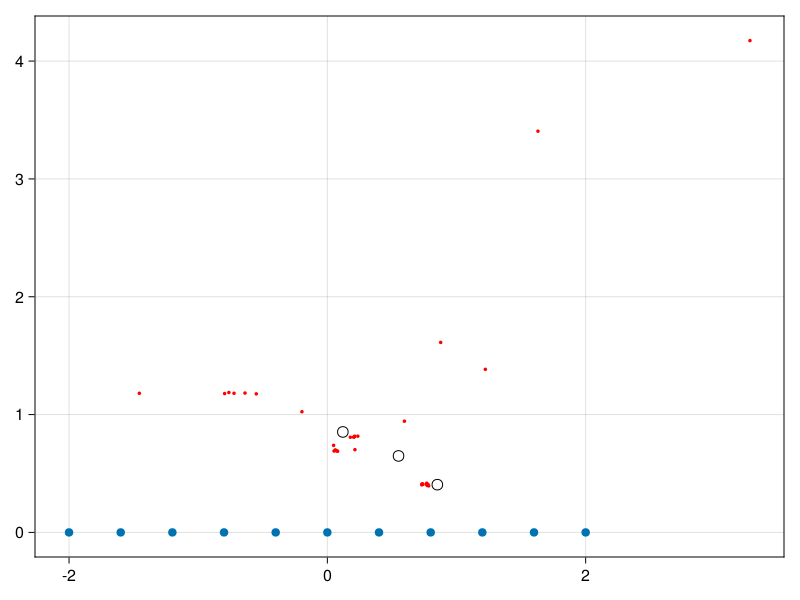

In [449]:
#scatter(xgood_array[1,:],xgood_array[2,:],markersize=5)
scatter(xtop_array[1,:],xtop_array[2,:],markersize=5,color=:red)
#scatter(xmean_array[1,:],xmean_array[2,:],markersize=5)
scatter!(real(truez),imag(truez),marker=:circle,markersize=15,color=:transparent,strokewidth=1)
scatter!(real(sens),imag(sens))
current_figure()

In [321]:
# using x error
#=
minxerr, bestone = findmin(collection_xerr)
xthresh = minxerr + 50.0
bestsol = sol_collection[bestone];
goodones = findall(x -> x <= xthresh,collection_xerr)
badones = findall(x -> x > xthresh,collection_xerr);

xgood = collect_estimated_states(sol_collection[goodones],obs.config);
xbad = collect_estimated_states(sol_collection[badones],obs.config);
=#

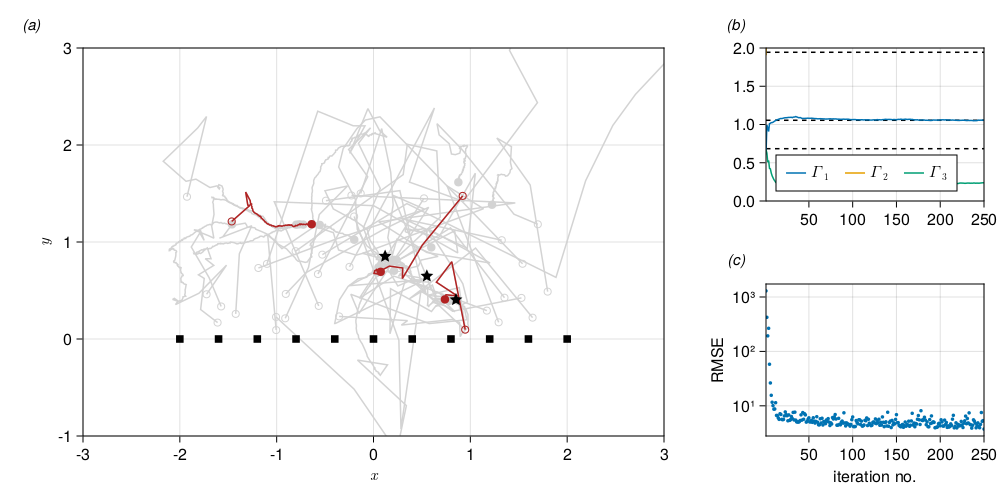

In [450]:
fulltraj = true
plotbadones = false

sampsol = bestsol #sol_collection[goodones[2]]

ftraj = Figure(;resolution=(1000,500))
ga = ftraj[1,1] = GridLayout()
gb = ftraj[1,2] = GridLayout()

axtraj = Axis(ga[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
with_theme(LowRankVortex.trajectory_theme()) do    
    
    if fulltraj
        for this_solhist in sol_bestones
            trajectory!(axtraj,this_solhist,obs,color=:lightgray)
        end
        if plotbadones
            for this_solhist in sol_collection[badones]
                trajectory!(axtraj,this_solhist,obs,color=LowRankVortex.color_palette[3])
            end
        end
        trajectory!(axtraj,bestsol,obs,color=LowRankVortex.color_palette[1])
    else
        xpost = vec(xgood[1,:])
        ypost = vec(xgood[2,:])
        Γpost = vec(xgood[3,:])
        scatter!(axtraj,xpost,ypost,markersize=5,color=LowRankVortex.color_palette[1])
        xbestpost = xbest_array[1,1:obs.config.Nv]
        ybestpost = xbest_array[2,1:obs.config.Nv]
        Γbestpost = xbest_array[3,1:obs.config.Nv]
        scatter!(axtraj,xbestpost,ybestpost,markersize=20,color=LowRankVortex.color_palette[2])
        xcenter = goodstate[1,:]
        ycenter = goodstate[2,:]
        Γcenter = goodstate[3,:]
        #scatter!(axtraj,xcenter,ycenter,markersize=20,color=LowRankVortex.color_palette[4])
    end
    scatter!(axtraj,real(sens),imag(sens),marker=:rect,color=:black)
    scatter!(axtraj,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
end
#save("soltraj-1vortex-3sensor.pdf",ftraj)   

gb1 = gb[1,1] = GridLayout()
gb2 = gb[2,1] = GridLayout()
axa = Axis(gb1[1,1];limits=(1,length(sampsol),0,2))
ztrue, Γtrue = state_to_positions_and_strengths(x_true,config_data_true)
for j in 1:config_data_true.Nv
    #lines!(axa,real(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    #lines!(axa,imag(ztrue[j])*ones(length(sampsol)),linestyle=:dash)
    lines!(axa,Γtrue[j]*ones(length(sampsol)),linestyle=:dash,color=:black)
end
for j in 1:obs.config.Nv
    #lines!(axa,map(x -> mean(x.Xf)[2j-1],sampsol),markersize=2,label=L"x")
    #lines!(axa,map(x -> mean(x.Xf)[2j],sampsol),markersize=2,label=L"y")
    lines!(axa,map(x -> mean(x.Xf)[2obs.config.Nv+j],sampsol),markersize=2,label=L"\Gamma_{%$j}")
end
axislegend(axa,orientation=:horizontal,position=:lb)

yerrhist = map(x -> x.yerr,sampsol)
axb = Axis(gb2[1,1];yscale=log10,xlabel="iteration no.",ylabel="RMSE")
linkxaxes!(axb,axa)
pl = scatter!(axb,yerrhist,markersize=5)
xlims!(axb,(1,length(yerrhist)))
#save("convergence-1vortex-3sensor.pdf",f)

colsize!(ftraj.layout, 2, Auto(0.35))

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb1, gb2])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 20, 15, 0),
        halign = :right)
end

#save("trajectories-1vortex-3sensor-case2.pdf",ftraj)
ftraj

In [703]:
dx = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[1],solhist);
dy = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[2],solhist);
dΓ = map(x -> mean((sqrt(x.Σx)*x.V*x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)))[3],solhist);
#scatter(cumsum(dx),cumsum(dy))

#### Plotting the pressure

In [451]:
vort_post = state_to_lagrange_reordered(xbest,obs.config;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(xbest,obs)
p_post_field = analytical_pressure(zg,vort_post,obs.config);

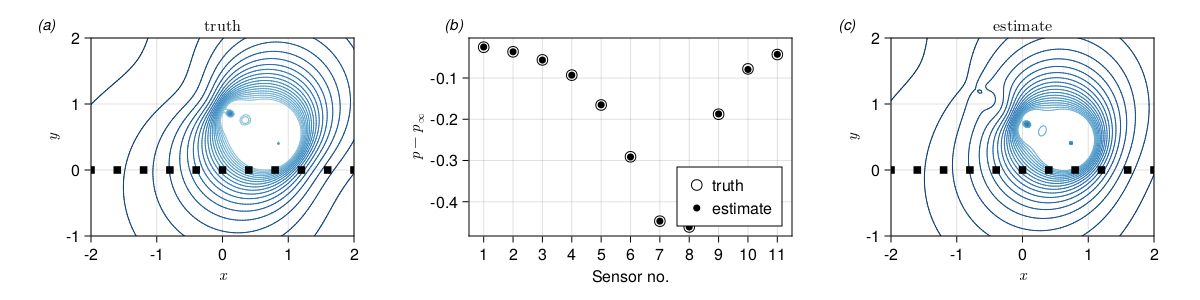

In [452]:
l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
contour!(axleft,xg,yg,ptrue_field,levels=l,colormap=:RdBu)
scatter!(axleft,real.(sens),imag.(sens),marker=:rect,color=:black)
contour!(axright,xg,yg,p_post_field,levels=l,colormap=:RdBu)
scatter!(axright,real.(sens),imag.(sens),marker=:rect,color=:black)

#f = Figure(;resolution=(500,400))
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
scatter!(axcenter,ystar,markersize=15,color=:transparent,strokewidth=1,label="truth")
scatter!(axcenter,y_post,markersize=10,color=:black,label="estimate")
axislegend(axcenter,position=:rb)

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-1vortex-3sensor-case2.pdf",f)

f

#### Plotting the cost function

In [1005]:
# start with the final mean state
xmin, xmax = -2, 2
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)

jdex = length(bestsol)
sol = bestsol[jdex]
xbase = mean(sol.X)

jdex = 5
sol0 = bestsol[jdex]
xbase0 = mean(sol0.X)

Nv = obs.config.Nv

costmap = zeros(length(xg),length(yg))
costmap_p = zeros(length(xg),length(yg))
costmap_m = zeros(length(xg),length(yg))

xij = copy(xbase)
xij0 = copy(xbase0)

v_explore = 2

for (j,yj) in enumerate(yg)
    xij[2v_explore] = yj
    xij0[2v_explore] = yj
    for (i,xi) in enumerate(xg)
        xij[2v_explore-1] = xi
        hx = observations(xij,obs)
        costmap[i,j] = norm(ystar-hx,sol.Σy)
        xij0[2v_explore-1] = xi
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore] + 0.3
        hx_p = observations(xij0,obs)
        costmap_p[i,j] = norm(ystar-hx_p,sol.Σy)
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore] - 0.3
        hx_m = observations(xij0,obs)
        costmap_m[i,j] = norm(ystar-hx_m,sol.Σy)
        xij0[2Nv+v_explore] = xbase[2Nv+v_explore]
    end
end

In [1006]:
[minimum([minimum(costmap_p),minimum(costmap)]),maximum([maximum(costmap_p),maximum(costmap)])]

2-element Vector{Float64}:
   2.2778558341112016
 781.682816841373

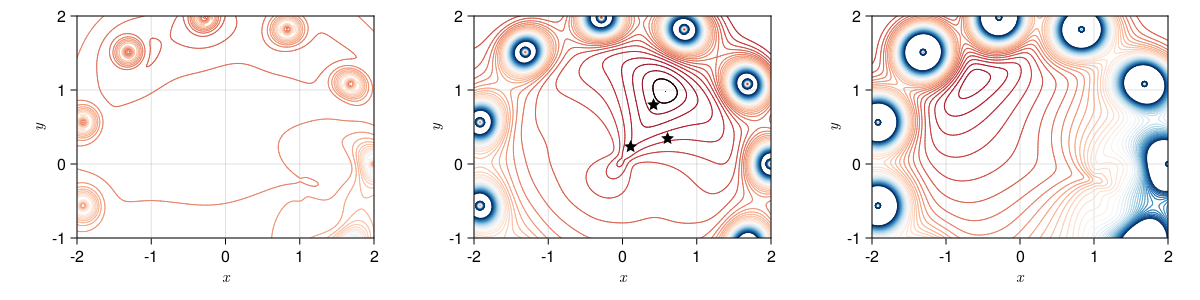

In [1007]:
minc = minimum([minimum(costmap_p),minimum(costmap)])
dc = 300 # maximum([maximum(costmap_p),maximum(costmap)])
f = Figure(;resolution=(1200,300))
ga = f[1,1] = GridLayout()
gb = f[1,2] = GridLayout()
gc = f[1,3] = GridLayout()
axa = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
axb = Axis(gb[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
axc = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect())
linkaxes!(axb,axa)
linkaxes!(axc,axa)
pa = contour!(axa,xg,yg,costmap_m,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
contour!(pa,xg,yg,costmap_m,levels=[minc],color=:black)
pb = contour!(axb,xg,yg,costmap,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
l = pb.attributes[:levels].val[2]
contour!(pb,xg,yg,costmap,levels=[l],color=:black)
scatter!(pb,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
pc = contour!(axc,xg,yg,costmap_p,levels=range(minc,minc+dc,length=41),
    colorrange=(minc,minc+dc),colormap=:RdBu)
#save("errorfunc-1vortex-3sensor-case2.pdf",f)
f

In [1008]:
zmean_1vortex, Γmean_1vortex = state_to_positions_and_strengths(mean(bestsol[end].X),config_1vortex_data)
transpose([vortexmoment(0,zv,Γv) vortexmoment(0,zmean_1vortex,Γmean_1vortex) vortexmoment(1,zv,Γv)/vortexmoment(0,zv,Γv) vortexmoment(1,zmean_1vortex,Γmean_1vortex)/vortexmoment(0,zmean_1vortex,Γmean_1vortex)])

4×1 transpose(::Matrix{ComplexF64}) with eltype ComplexF64:
  2.3265442402896843 + 0.0im
  2.3205731283403104 + 0.0im
 0.22311955671696976 + 0.3901459595209079im
 0.20053817740994953 + 0.3732964458631035im

In [26]:
solhist[end].V

3×3 Matrix{Float64}:
 -0.00755809   0.999962    -0.00429278
 -0.985451    -0.00671935   0.169826
  0.169791     0.00551389   0.985465

In [27]:
solhist[end].Λx

3-element Vector{Float64}:
 594.1038936212367
 116.28626229574081
   1.647571849018611

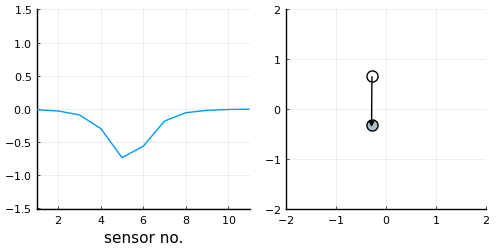

In [28]:
showmode(50,1,solhist,config_1vortex_data,size=(500,250),markersize=8,xlim=(-2.0,2.0),ylim=(-2.0,2.0))

In [29]:
solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)

3×3 Matrix{Float64}:
  0.0409346    2.0098e-5    0.00184311
 -5.94799e-5   0.0924307    0.000353381
  0.000312875  0.000422218  0.595419

### Multiple vortices

In [593]:
Nv = 2
δ = 0.2

config_data = VortexConfig(Nv, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #5e-4 #1e-3
ϵX = 5e-3 #5e-3 #0.05
ϵΓ = 5e-3 #5e-3 #0.05

# ranges to confine the prior to
xr = (-1.5,1.5)
yr = (0.0,1.5)
Γr = (0.0,2.0)

obs = PressureObservations(sens,config_data);

In [594]:
sol_collection = vortexinference(ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,obs,linear_flag=false,maxiter=250,errtol=0.025,numsample=20,inflate=true);

In [595]:
collection_yerr = map(x -> x[end].yerr,sol_collection)

20-element Vector{Float64}:
  80.50728779749859
  16.21516379261435
  18.55933440793088
  24.173439853224945
 109.90993875549869
 223.45358902249373
   7.35517865227772
  29.03021019760188
  18.585267106233214
  13.577163147438895
 170.09191967145583
   7.368878180280386
  15.029559944709705
  15.752448348778731
   0.02301091929209901
  14.650804871986628
  19.117430759372205
  19.143889816631464
  86.42525764294972
  94.59460655305911

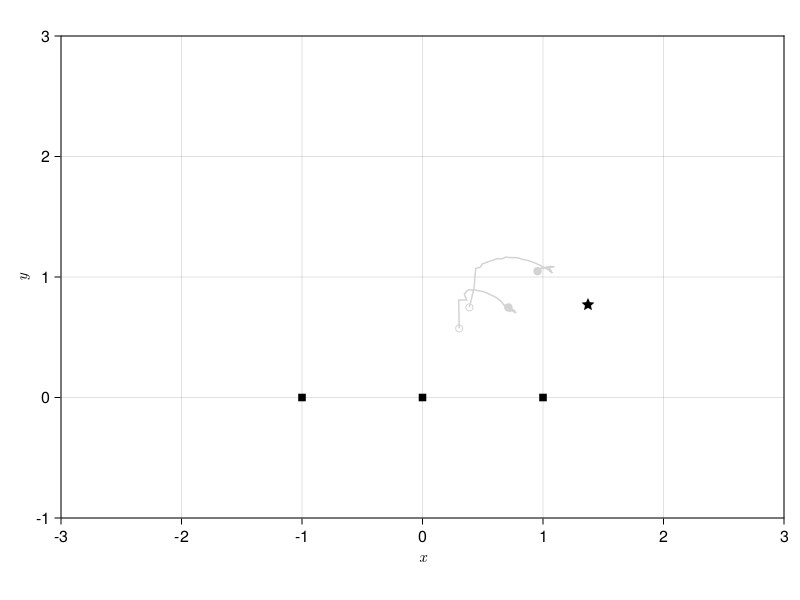

In [596]:
f = Figure()
axtraj = Axis(f[1,1];limits=(-3,3,-1,3),aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
with_theme(LowRankVortex.trajectory_theme()) do    
    #for this_solhist in sol_collection[goodones]
        trajectory!(axtraj,sol_collection[2],obs,color=:lightgray)
    #end
    #trajectory!(axtraj,bestsol,obs,color=LowRankVortex.color_palette[1])
    scatter!(axtraj,real(sens),imag(sens),marker=:rect,color=:black)
    scatter!(axtraj,real(truez),imag(truez),marker=:star5,markersize=15,color=:black)
end
f

In [123]:
perr = []
for solhist in sol_collection
    jdex = length(solhist)
    vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
    p_post_field = analytical_pressure(zg,vort_post,config_data)
    push!(perr,norm(ptrue_field-p_post_field)/norm(ptrue_field))
end

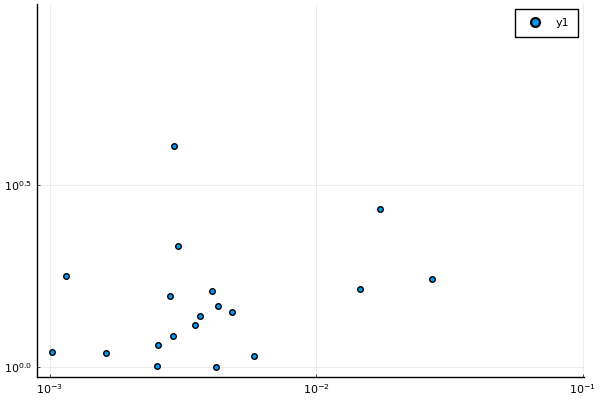

In [33]:
scatter(collection_err*ϵmeas,perr,scale=:log10)

In [130]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

In [131]:
minerr

2.679486384986046

In [36]:
perr[sampnum]

1.1039726302191541

In [677]:
minperr, sampnum = findmin(perr)
solhist = sol_collection[sampnum];
minerr = collection_err[sampnum]

8.555369230739387

In [918]:
minerr*ϵmeas

0.000823171294532819

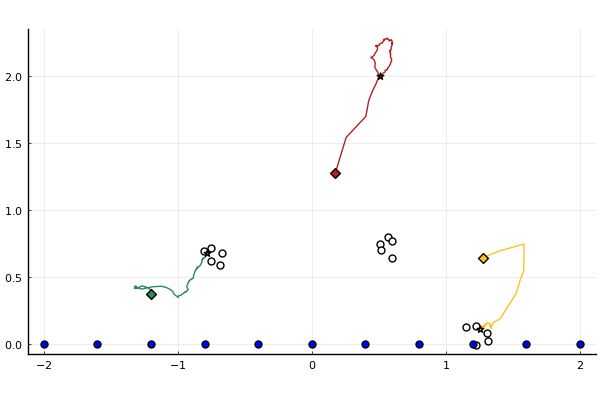

In [132]:
pl = filtertrajectory(solhist,obs,vort,markersize=5,legend=:false)
#savefig("3cluster-traj-3vortex-11linesensors.pdf")
#display(pl)

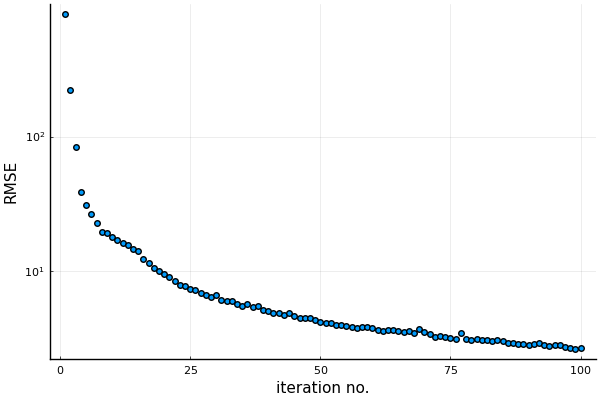

In [133]:
yerrhist = map(x -> x.yerr,solhist)
scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lW9ll/src/animation.jl:137


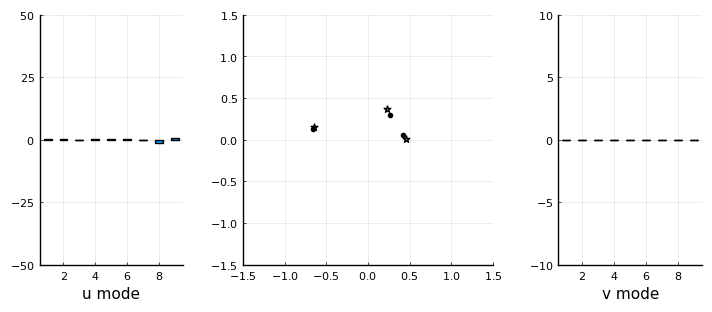

Plots.AnimatedGif("/Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif")
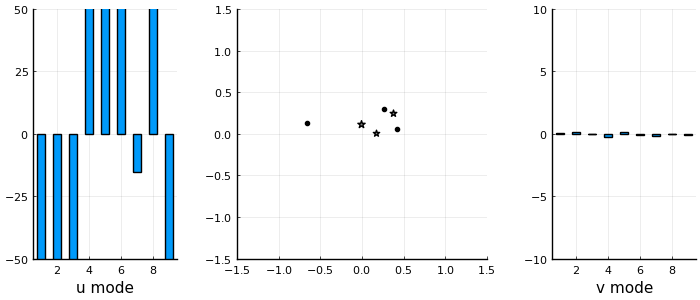

In [778]:
@gif for j in 1:length(solhist)
    filterstepplot(j,solhist,x_true,xlim=(-1.5,1.5),ylim=(-1.5,1.5),size=(700,300),arrows_on=false,ubarscale=0.1,vbarscale=0.1)
end every 2

The Kalman gain isn't diagonally dominant. Mixes U and V modes together. In particular, higher U modes affect most V modes.

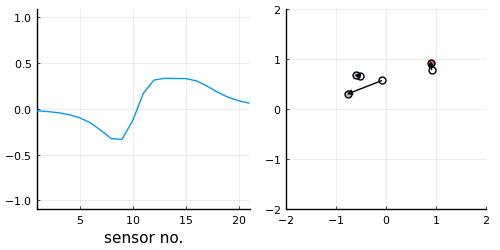

In [344]:
showmode(100,2,solhist,config_data,size=(500,250),xlim=(-2,2),ylim=(-2,2))

In [345]:
(solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)).diag

9-element Vector{Float64}:
 0.26691182937350977
 0.4612485658255621
 0.4992840956956534
 0.48894157312115305
 0.40584969917653485
 0.35102396492451765
 0.30115145006403
 0.1261610131156297
 0.057328954009867435

In [134]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = observations(mean(solhist[jdex].X),obs)
p_post_field = analytical_pressure(zg,vort_post,config_data)
vort_post

3-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(0.5062726276565196 + 1.9914461182948457im, -0.3709634624156531, 0.2)
 Vortex.Blob(-0.7805035252254179 + 0.6781614048010681im, 0.5580201950784153, 0.2)
 Vortex.Blob(1.2538800326167074 + 0.1173340577552869im, 0.6215766738713608, 0.2)

In [41]:
vortexmoment(1,zv_post,Γ_post)

-1.5334675960989748 + 2.486371056137739im

In [42]:
vortexmoment(1,zv,Γv)

-1.5888933471547861 + 2.5957058796524626im

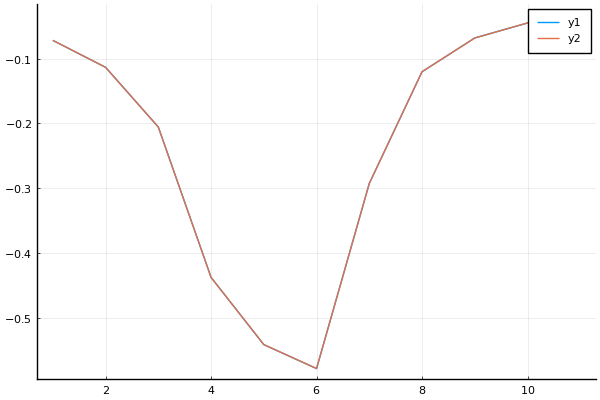

In [43]:
plot(y_post)
plot!(ystar)

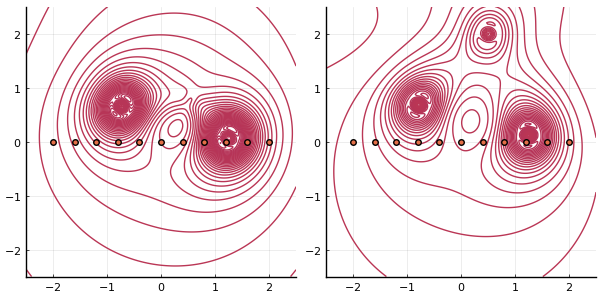

In [136]:
#l = range(-1,1,length=31)
#cl = (-1,1)
pl1 = plot(xg,yg,ptrue_field',ratio=1,clim=cl,levels=31,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl1,real.(sens),imag.(sens))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = plot(xg,yg,p_post_field',ratio=1,clim=cl,levels=31,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl2,real.(sens),imag.(sens))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-3vortex-11linesensors.pdf")
#display(p1)

In [45]:
norm(ptrue_field-p_post_field)/norm(ptrue_field)

1.1039726302191541

### Explore the cost function topology
Here, we will map out the cost function's dependence on two components of the state, while
keeping the others fixed.

In [1591]:
# start with the final mean state
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)

jdex = 500 #length(solhist)
xbase = mean(solhist[jdex].X)

costmap = zeros(length(xg),length(yg))
costmap_p = zeros(length(xg),length(yg))
costmap_m = zeros(length(xg),length(yg))

xij = copy(xbase)

v_explore = 3

for (j,yj) in enumerate(yg)
    xij[2v_explore] = yj
    for (i,xi) in enumerate(xg)
        xij[2v_explore-1] = xi
        hx = observations(xij,pressure,sens,config_data)
        costmap[i,j] = norm(ystar-hx,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] + 0.05
        hx_p = observations(xij,pressure,sens,config_data)
        costmap_p[i,j] = norm(ystar-hx_p,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] - 0.05
        hx_m = observations(xij,pressure,sens,config_data)
        costmap_m[i,j] = norm(ystar-hx_m,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore]
    end
end

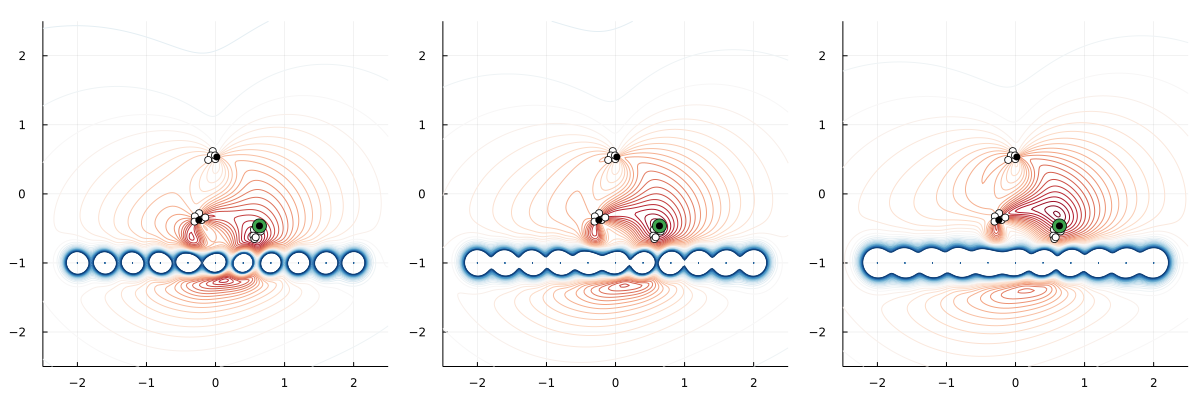

In [1592]:
truex = x_true[1:2:2Nv_true]
truey = x_true[2:2:2Nv_true]
currentx = xbase[1:2:2Nv]
currenty = xbase[2:2:2Nv]
minc = 0.3 #minimum([minimum(costmap_p),minimum(costmap),minimum(costmap_m)])
p1 = plot(xg,yg,costmap',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1,truex,truey,markercolor=:white,legend=false)
scatter!(p1,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_p = plot(xg,yg,costmap_p',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_p,truex,truey,markercolor=:white,legend=false)
scatter!(p1_p,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_p,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_m = plot(xg,yg,costmap_m',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_m,truex,truey,markercolor=:white,legend=false)
scatter!(p1_m,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_m,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

plot(p1_m,p1,p1_p,layout=(1,3),size=(1200,400))

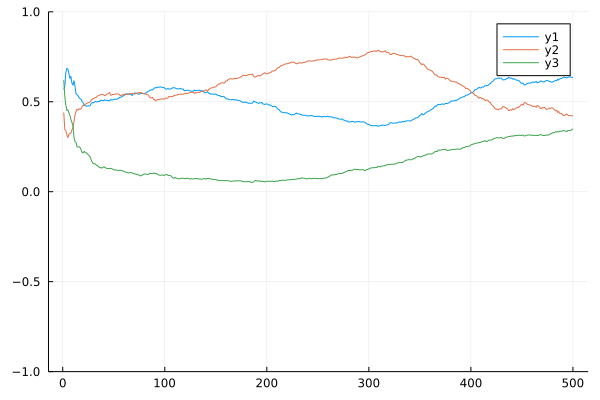

In [1571]:
plot(map(x -> mean(x.X)[2Nv+1],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+2],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+3],solhist),ylim=(-1,1))

In [555]:
#=
q = 10
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

i1, j1 = 3, 7
P = zeros(q,q)
for j in 1:q
    P[j,j] = 1.0
end
v = P[:,i1]
P[:,i1] .= P[:,j1]
P[:,j1] .= v
P;

dθ = Uniform(0,π)
dln = LogNormal(-2,1);;
[mean(dln) std(dln)]

dθ = Uniform(0,π)
dln = LogNormal(-2,1);
#dln = Chi(2);

q = 40
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

x̃, ỹ = zeros(q), zeros(q)
for j in 2:q
    zj = rand(dln)*exp(im*rand(dθ))
    x̃[j] = real(zj)
    ỹ[j] = imag(zj)
end

x = inv(A)*x̃;
y = inv(A)*ỹ;
scatter(x,y,ratio=1)
=#

In [302]:
dy̆ = hcat(map(x -> vcat(mean(x.Y̆),zeros(6-length(mean(x.Y̆)))),solhist)...);

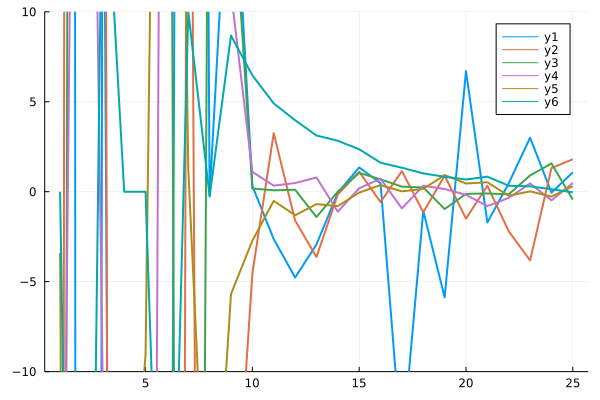

In [312]:
plot(dy̆[1,:],linewidth=2,ylim=(-10,10))
plot!(dy̆[2,:],linewidth=2)
plot!(dy̆[3,:],linewidth=2)
plot!(dy̆[4,:],linewidth=2)
plot!(dy̆[5,:],linewidth=2)
plot!(dy̆[6,:],linewidth=2)

In [290]:
dx̆ = hcat(map(x -> mean(x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)),solhist)...);

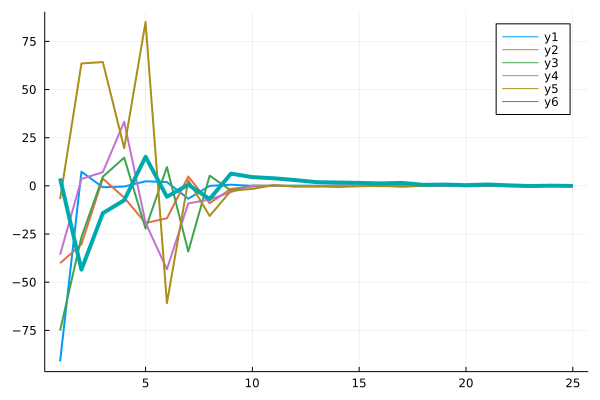

In [306]:
plot(dx̆[1,:],linewidth=2)
plot!(dx̆[2,:],linewidth=2)
plot!(dx̆[3,:],linewidth=2)
plot!(dx̆[4,:],linewidth=2)
plot!(dx̆[5,:],linewidth=2)
plot!(dx̆[6,:],linewidth=4)

In [79]:
sqrt(Σx)*Fhist[end].V[:,1:rhist[end]]*K̃*ỹhist[end]

9-element Vector{Float64}:
  0.0018490395330256174
 -0.005118568346242631
 -0.00357188260657286
 -0.00446458150403976
  0.008487842822575746
  0.007777494563758844
  0.0025521443428678826
  0.0045746465120252025
  0.0025497897622294495

36-element Vector{Float64}:
 1321.9159271767949
  197.92969822660362
   60.65322971203477
   14.070451613159014
    2.524231697075501
    0.08879175290868446
    0.0024909038486424285
    0.0003641957099004161
    8.743238899015276e-5
    1.1374831855011818e-5
    1.1561468627527092e-6
    6.920089409510231e-9
    2.6473141167366238e-9
    ⋮
    2.4868995751603507e-14
    2.259396132881637e-14
    1.4422580366206255e-14
    1.4210854715202004e-14
    1.0552812029956029e-14
    9.978272503795993e-15
    9.166656117039269e-15
    7.54697596667468e-15
    7.105427357601002e-15
    5.985093828153431e-15
    5.80939686960131e-15
    4.273885897591831e-15

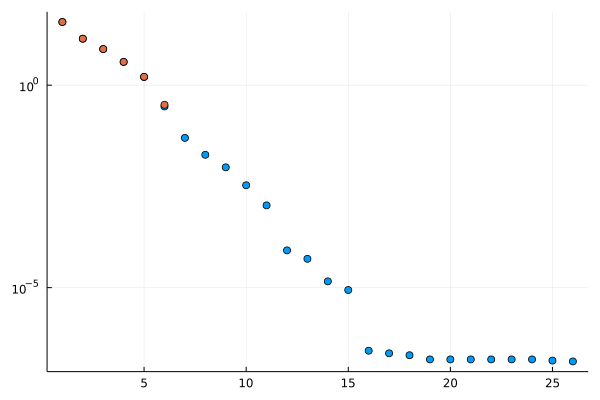

In [218]:
Λx = solhist[end].Λx[solhist[end].Λx.>100*eps()]
Λy = solhist[end].Λy[solhist[end].Λy.>100*eps()]
pl = scatter(sqrt.(Λy),yscale=:log10,legend=false)
scatter!(pl,sqrt.(Λx),yscale=:log10,legend=false)

#savefig("4vortex-svalues.pdf")
#savefig("4vortex-svalues.png")
display(pl)

In [98]:
LowRankVortex.P

9×9 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0459763   0.180721    -0.466078   -0.664597   …  -0.231686    0.0589482
  0.0788804   0.00428573   0.5093      0.0835935      0.144961    0.278253
  0.16449    -0.0732933   -0.140497    0.307257      -0.443203    0.0570702
  0.826368   -0.026383    -0.299224    0.252782      -0.0776115  -0.0232306
 -0.231958    0.659137    -0.13104     0.492813       0.098887    0.0212657
 -0.0686195   0.535204    -0.0629612   0.0229107  …  -0.31879    -0.054013
 -0.0602487  -0.0762433   -0.49928     0.106125       0.689798   -0.213156
 -0.280826   -0.279705    -0.361859    0.22372       -0.0813069   0.771225
 -0.375122   -0.395349    -0.112926    0.297177      -0.359191   -0.521258

In [99]:
V[1:2,1] + V[4:5,1] + V[7:8,1]

2-element Vector{Float64}:
  0.7201431166604436
 -0.43390344986838764

In [961]:
unitvec = zeros(length(x_post))
unitvec[6] = 1.0
F.Vt*unitvec

6-element Vector{Float64}:
  0.574771771360253
  0.22247709382174288
 -0.3319587477794311
  0.11918085260192823
 -0.24380484125187668
  0.6605299895538166

In [1318]:
F.V[:,1]

9-element Vector{Float64}:
 -0.0013365146346376764
 -0.3437027395751458
  0.0829705149437211
 -0.3194680056247702
 -0.08144756026540528
 -0.32315728742537086
  0.259381193123849
  0.5453208346181756
  0.5451650888170947

In [1319]:
cumsum(F.S)/sum(F.S)

9-element Vector{Float64}:
 0.5459333120939325
 0.7545316235684618
 0.8396933430067108
 0.9155493243748806
 0.9677749179838403
 0.9879966879557416
 0.9990439288567136
 0.9997043000270978
 0.9999999999999999